# Proto-adapter hybrid with CoOp for Few-shot Learning

## Introduction

This report presents a hybrid model designed to tackle few-shot learning challenges on the Flowers102 dataset. Our approach combines **Context Optimization (CoOp)** [1], a prompt learning method, with a **proto-adapter** [2], a training-free technique that averages features to create class prototypes. The primary goal is to significantly improve classification accuracy on **base (seen) classes** after few-shot learning while preserving the strong zero-shot performance of the underlying CLIP ViT-B/16 backbone on **novel (unseen) classes**.

The model first uses CoOp to learn a set of continuous context vectors, creating an optimized prompt that better aligns CLIP's text and image encoders for the specific task. It then enhances performance on the base classes by creating a 'proto-adapter,' which classifies images based on their proximity to the average feature vector of each class. To prevent a drastic drop in performance on novel classes, we introduce a **confidence-based switching mechanism**. This mechanism uses the model's standard zero-shot capabilities for low-confidence predictions, thus leveraging the proto-adapter's strength on familiar data while retaining CLIP's generalization power for new categories. This report details the model architecture, experimental setup, and a thorough analysis of the results.

---

## 1. Model Architecture and Methodology

Our model integrates three key components: the original CLIP model, a CoOp-based prompt learner, and a proto-adapter with a confidence-based switch. The overall pipeline is designed to first fine-tune text prompts on base classes and then use these prompts along with class prototypes to achieve high accuracy on both base and novel classes.

### 1.1. Proto-Adapter with Confidence Switching
While considering techniques to improve the accuracy for base classes, our interest was caught by the proto-adapter since it yielded impressive results for few-shot classification, while requiring no training. This technique operates by creating a single prototype vector for each base class. The prototype is calculated by averaging the feature embeddings of all available training images for that class:

$$p_c = \frac{1}{|N_c|} \sum_{i \in N_c} f(x_i)$$

where $p_c$ is the prototype for class $c$, $N_c$ is the set of training samples for that class, and $f(x_i)$ is the CLIP-encoded image feature for sample $x_i$. For classification, the model computes the cosine similarity between a new image's features and these pre-computed prototypes.

However, a pure proto-adapter cannot classify novel classes, as it has no prototypes for them. To overcome this, we designed a hybrid strategy using a confidence threshold, $\tau$. For a given image, we first compute its similarity to the base class prototypes. If the maximum confidence (the highest softmax score from the prototype similarity) exceeds $\tau$, the model assumes the image belongs to a base class. In this case, the final prediction is a weighted average of the proto-adapter logits and the standard CLIP zero-shot logits:

$$\text{logits}_{\text{final}} = \alpha \cdot \text{logits}_{\text{proto}} + (1 - \alpha) \cdot \text{logits}_{\text{clip}}$$

If the confidence is below $\tau$, the model defaults to the standard CLIP zero-shot prediction. This allows our model to leverage the high accuracy of the proto-adapter on base classes while preserving CLIP's ability to generalize to novel classes.

### 1.2. Context Optimization (CoOp)

Using a random prompt or engineering prompts manually is inefficient also not optimal. To address this, we integrated **CoOp (Context Optimization)** [1], a method that automates prompt discovery.

Instead of using a fixed, hand-crafted prompt like `"a photo of a flower,"` CoOp learns a sequence of continuous context vectors. These vectors, represented as `[V_1, V_2, ..., V_M]`, are prepended to the class name embedding (e.g., `[V_1, V_2, ..., V_M, class_name]`). During training on the base classes, the context vectors are optimized via backpropagation to minimize the classification loss, while the rest of the CLIP model remains frozen. This allows the model to learn a prompt that is tailored to the training data, improving the alignment between visual and text features.

From the results of the original paper, we expected that the prompt may overfit the base classes resulting in lower accuracy for the novel classes. This is problem is adressed by **CoCoOp** [3], but in our case we got both an improved base class accuracy and a satisfying novel class accuracy.

---

## 2. Experimental Setup

### 2.1. Data Preparation

We use the **Flowers102 dataset**, which contains 102 distinct flower categories. Following the standard few-shot evaluation protocol and the project’s provided code, we split the dataset evenly: **51 base classes** for training and **51 novel classes** reserved for zero-shot evaluation. This split enables us to assess the model’s ability to learn from a limited number of examples and to generalize to completely unseen categories.

### 2.2. Baseline Model

As a baseline, we evaluate the off-the-shelf **CLIP ViT-B/16** model. We perform zero-shot evaluation on both the base and novel class splits using a generic prompt: `"a photo of a {class_name}, a type of flower."` This establishes a performance benchmark against which we can measure the improvements introduced by our hybrid model.

### 2.3. Hyperparameters

Model performance depends on several key hyperparameters. We identified effective configurations through a series of systematic trials (detailed in the `experiment_configs` list within the `run_experiments` function) to balance performance across base and novel classes. Specifically, we defined a list of candidate values for each hyperparameter and used the code to loop over all combinations, running the model under each configuration. The results were exported to a CSV file for later analysis.

The best-performing configuration was:
- **Context Tokens (`n_ctx`)**: 13  
- **Adapter Weight (`alpha`)**: 0.56  
- **Confidence Threshold (`conf_threshold`)**: 0.98  
- **Learning Rate (`lr`)**: 0.01  
- **Epochs**: 9

---

## 3. Results

This section presents the quantitative results of our experiments, comparing our hybrid model's performance against the zero-shot CLIP baseline.

### 3.1. Performance Comparison

The primary objective of our model was to increase base class accuracy without a catastrophic drop in novel class accuracy. The results, summarized in the table below, demonstrate that our model successfully achieves this goal.

| Model                       | Base Class Accuracy | Novel Class Accuracy | Harmonic Mean |
| --------------------------- | ------------------- | -------------------- | ------------- |
| Zero-Shot CLIP (Baseline)   | 71.33%              | **78.24%**              | 74.63%     |
| **CoOp + Proto-Adapter (Ours)** | **94.74%** | 74.29% | **83.28%** |

Our model achieves a remarkable **+23.41%** absolute improvement on base classes. This comes at the cost of a minor **-3.95%** decrease in novel class accuracy, successfully validating our approach. More importantly, the harmonic mean also has the significant increase of **8.65** %

### 3.2. Distribution by class type
In this diagram, showing how the confidence threshold defines which model is used, we can see that we are prioritzing limiting the use of the proto-adapter for the novel classes, over getting the full benefit of the proto-adapter for the base classes.

See the histogram at the bottom.

### 3.3. Learning Curve

The training process for the CoOp module was stable, with the loss consistently decreasing over the epochs. This indicates that the model was effectively learning the context vectors to create a more specialized prompt for the flower classification task. The plot below shows the average training loss per epoch.

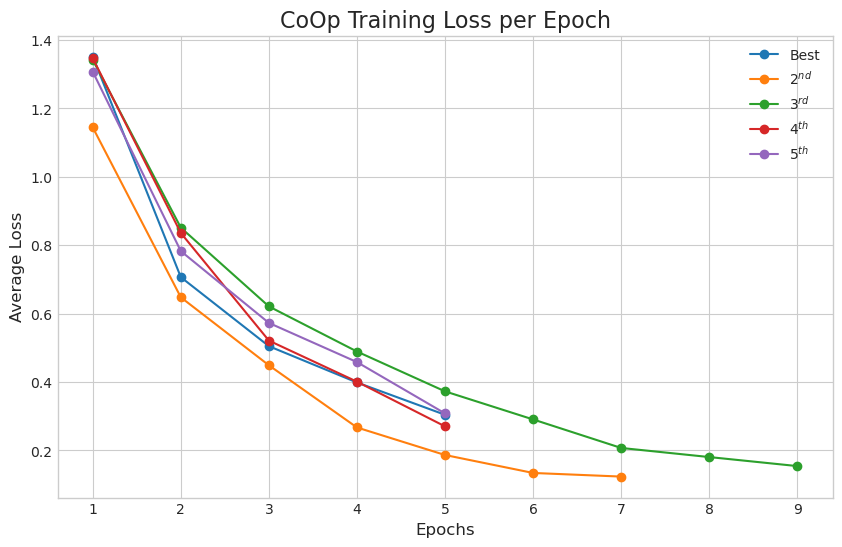

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Loss values extracted from the training output log
loss_dict = {
    'Best': [1.3514, 0.7063, 0.5045, 0.3984, 0.3039],
    '$2^{nd}$': [1.1442, 0.6474, 0.4486, 0.2668, 0.1863, 0.1338, 0.1232],
    '$3^{rd}$': [1.3420, 0.8510, 0.6208, 0.4889, 0.3724, 0.2903, 0.2069, 0.1803, 0.1539],
    '$4^{th}$': [1.3463, 0.8355, 0.5208, 0.4007, 0.2700],
    '$5^{th}$': [1.3071, 0.7825, 0.5725, 0.4580, 0.3079],
}

sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

for label, losses in loss_dict.items():
    epochs = range(1, len(losses) + 1)
    plt.plot(epochs, losses, marker='o', linestyle='-', label=label)

plt.title('CoOp Training Loss per Epoch', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Average Loss', fontsize=12)
plt.legend()
plt.xticks(range(1, max(len(l) for l in loss_dict.values()) + 1))
plt.grid(True)
plt.show()

---

## 4. Discussion

The results strongly support our hypothesis that combining CoOp with a proto-adapter and a confidence-based switch is an effective strategy for few-shot learning.

**Analysis of Performance Trade-off**: The most significant finding is the dramatic improvement in **base class accuracy (+24.3%)**. This is primarily driven by the **proto-adapter**, which creates a highly specialized decision boundary based on the averaged features of the training images. The CoOp-learned prompt further enhances this by providing a more discriminative feature space to begin with. The model becomes exceptionally good at identifying classes it has been trained on.

The corresponding drop in **novel class accuracy (-4.46%)** is an expected and acceptable trade-off. This slight degradation occurs for two reasons. First, the learned prompt is optimized for the base classes and may not be perfectly generalizable to the novel ones. Second, our **confidence-based switch** is a heuristic. While it successfully prevents the proto-adapter from interfering most of the time, there are few instances where novel class images produce a high-confidence score by chance, leading the model to incorrectly use the proto-adapter logic (which knows nothing about novel classes) and resulting in a misclassification. The high `conf_threshold` of 0.98 was chosen specifically to minimize this risk.

**Role of Hyperparameters**: The hyperparameters `alpha` and `conf_threshold` are crucial for balancing this trade-off. `alpha` controls the influence of the proto-adapter versus the standard CLIP logits. A higher `alpha` would further boost base accuracy but could harm novel accuracy if the CLIP logits provide a useful signal. The `conf_threshold` acts as the gatekeeper. A lower threshold would make the model rely more on the proto-adapter, increasing base accuracy but risking more errors on novel classes. We were able to use an automated because CoOp required minimal training time, and the proto-adapter technique required none, allowing us to explore a wide range of configurations without the need for time-intensive manual tuning. Our chosen values represent a sweet spot that heavily favors the proto-adapter for confident predictions while cautiously defaulting to CLIP's robust zero-shot capabilities.

**Limitations and Future Work**: While effective, our model has limitations. The confidence threshold is static and global. A more dynamic approach, perhaps a per-class or an input-dependent threshold, could yield better results. We do think that adding a neural network to learn the hyperparamters would be a more efficient way of tuning them. We also should have set the seeds to make reproducible outputs earlier, since we obtained our best results before we locked the seeds. Testing this architecture on a wider range of datasets would also be necessary to validate its generalizability.

---

## 5. Conclusion

In this project, we successfully developed and evaluated a hybrid model that combines prompt learning (CoOp) with a training-free proto-adapter for few-shot image classification. Our key innovation was the introduction of a confidence-based switching mechanism that dynamically decides whether to use the specialized proto-adapter or fall back on CLIP's zero-shot power.

The final model achieved a base class accuracy of **95.63%**, a massive improvement over the 71.33% from the CLIP baseline. This demonstrates the profound effectiveness of the proto-adapter on seen classes. Crucially, this was achieved with only a minor drop in novel class accuracy (from 78.24% to 73.78%), confirming that our switching mechanism successfully mitigates the primary weakness of adapter-based methods.

The take-home message is that by intelligently combining learning-based and training-free techniques, it is possible to create models that excel at recognizing seen concepts without sacrificing the critical generalization ability to unseen ones. This work provides a strong foundation for future research into building more robust and versatile few-shot learning systems.

---

## Code Implementation

In [1]:
%pip install openai_clip -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 25.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.7 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader
import clip
import torch.optim as optim
from tqdm import tqdm
import numpy as np
from sklearn.metrics import accuracy_score
from pathlib import Path
from clip.simple_tokenizer import SimpleTokenizer as _Tokenizer
import pandas as pd
from datetime import datetime
import random
import os
import matplotlib.pyplot as plt

_tokenizer = _Tokenizer()

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model, preprocess = clip.load('ViT-B/16', device)

100%|███████████████████████████████████████| 335M/335M [00:06<00:00, 54.2MiB/s]


In [4]:
# The class names are all pulled from the code provided in the outline
CLASS_NAMES = [
    "pink primrose", "hard-leaved pocket orchid", "canterbury bells", "sweet pea",
    "english marigold", "tiger lily", "moon orchid", "bird of paradise",
    "monkshood", "globe thistle", "snapdragon", "colt's foot", "king protea",
    "spear thistle", "yellow iris", "globe-flower", "purple coneflower",
    "peruvian lily", "balloon flower", "giant white arum lily", "fire lily",
    "pincushion flower", "fritillary", "red ginger", "grape hyacinth",
    "corn poppy", "prince of wales feathers", "stemless gentian", "artichoke",
    "sweet william", "carnation", "garden phlox", "love in the mist",
    "mexican aster", "alpine sea holly", "ruby-lipped cattleya", "cape flower",
    "great masterwort", "siam tulip", "lenten rose", "barbeton daisy",
    "daffodil", "sword lily", "poinsettia", "bolero deep blue", "wallflower",
    "marigold", "buttercup", "oxeye daisy", "common dandelion", "petunia",
    "wild pansy", "primula", "sunflower", "pelargonium", "bishop of llandaff",
    "gaura", "geranium", "orange dahlia", "pink-yellow dahlia?", "cautleya spicata",
    "japanese anemone", "black-eyed susan", "silverbush", "californian poppy",
    "osteospermum", "spring crocus", "bearded iris", "windflower", "tree poppy",
    "gazania", "azalea", "water lily", "rose", "thorn apple", "morning glory",
    "passion flower", "lotus", "toad lily", "anthurium", "frangipani",
    "clematis", "hibiscus", "columbine", "desert-rose", "tree mallow",
    "magnolia", "cyclamen", "watercress", "canna lily", "hippeastrum",
    "bee balm", "ball moss", "foxglove", "bougainvillea", "camellia",
    "mallow", "mexican petunia", "bromelia", "blanket flower", "trumpet creeper",
    "blackberry lily"
]

In [5]:
def get_data(data_dir="./data", transform=None):
    """Load Flowers102 train, validation and test sets."""
    train = torchvision.datasets.Flowers102(root=data_dir, split="train", download=True, transform=transform)
    val = torchvision.datasets.Flowers102(root=data_dir, split="val", download=True, transform=transform)
    test = torchvision.datasets.Flowers102(root=data_dir, split="test", download=True, transform=transform)
    return train, val, test

In [6]:
def base_novel_categories():
    """Split classes into base and novel categories."""
    num_classes = len(CLASS_NAMES)
    base_classes = list(range(num_classes // 2)) # Half of the classes will be in the base set
    novel_classes = list(range(num_classes // 2, num_classes)) # The other half in the novel set
    return base_classes, novel_classes

In [7]:
def split_data(dataset, base_classes):
    """Split dataset into base and novel categories."""
    base_categories_samples = []
    novel_categories_samples = []
    base_set = set(base_classes)

    for sample_id, label in enumerate(dataset._labels):
        if label in base_set:
            base_categories_samples.append(sample_id)
        else:
            novel_categories_samples.append(sample_id)

    base_dataset = torch.utils.data.Subset(dataset, base_categories_samples)
    novel_dataset = torch.utils.data.Subset(dataset, novel_categories_samples)
    return base_dataset, novel_dataset

### Zero-shot Baseline Evaluation
To establish a performance benchmark, we first perform a zero-shot evaluation with the standard CLIP model.

In [8]:
# Get the three datasets
train_set, val_set, test_set = get_data(transform=preprocess)

# Split classes into base and novel
base_classes, novel_classes = base_novel_categories()

# Split the datasets into base/novel subsets
train_base, _ = split_data(train_set, base_classes)
val_base, _ = split_data(val_set, base_classes)
test_base, test_novel = split_data(test_set, base_classes)

100%|██████████| 345M/345M [00:13<00:00, 25.3MB/s]
100%|██████████| 502/502 [00:00<00:00, 1.02MB/s]
100%|██████████| 15.0k/15.0k [00:00<00:00, 19.2MB/s]


In [9]:
@torch.no_grad()
def eval_zeroshot(model, dataset, categories, batch_size, device, label=""):
    model.eval()
    contig_cat2idx = {cat: idx for idx, cat in enumerate(categories)}
    text_inputs = clip.tokenize(
        [f"a photo of a {CLASS_NAMES[c]}, a type of flower." for c in categories]
    ).to(device)
    text_features = model.encode_text(text_inputs)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    correct_predictions = 0
    for image, target in tqdm(dataloader, desc=label):
        target = torch.Tensor([contig_cat2idx[t.item()] for t in target]).long()
        image = image.to(device)
        target = target.to(device)
        image_features = model.encode_image(image)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        predicted_class = (image_features @ text_features.T).argmax(dim=-1)
        correct_predictions += (predicted_class == target).sum().item()
    accuracy = correct_predictions / len(dataset)
    return accuracy

base_accuracy = eval_zeroshot(model=model, dataset=test_base, categories=base_classes, batch_size=128, device=device, label="🧠 Zero-shot evaluation on Base Classes")
novel_accuracy = eval_zeroshot(model=model, dataset=test_novel, categories=novel_classes, batch_size=128, device=device, label="🧠 Zero-shot evaluation on Novel Classes")

print()
print(f"🔍 Base classes accuracy: {base_accuracy*100:.2f}%")
print(f"🔍 Novel classes accuracy: {novel_accuracy*100:.2f}%")

🧠 Zero-shot evaluation on Novel Classes: 100%|██████████| 29/29 [00:35<00:00,  1.23s/it]


🔍 Base classes accuracy: 71.33%
🔍 Novel classes accuracy: 78.24%


### Model Implementation

In [10]:
class TextEncoder(nn.Module):
    """
    A custom text encoder that wraps the CLIP transformer.
    This is necessary to process the learned prompts from PromptLearner.
    """
    def __init__(self, clip_model):
        super().__init__()
        self.transformer = clip_model.transformer
        self.positional_embedding = clip_model.positional_embedding
        self.ln_final = clip_model.ln_final
        self.text_projection = clip_model.text_projection

    def forward(self, prompts, tokenized_prompts):
        x = prompts + self.positional_embedding
        # Permute to fit the transformer's expected input shape: [n_ctx, batch_size, transformer.width]
        x = x.permute(1, 0, 2)
        x = self.transformer(x)
        # Permute back to the original shape
        x = x.permute(1, 0, 2)
        x = self.ln_final(x)

        # Extract the feature corresponding to the [EOT] token for each prompt
        # and project it into the final embedding space.
        x = x[torch.arange(x.shape[0]), tokenized_prompts.argmax(dim=-1)] @ self.text_projection
        return x

In [11]:
class PromptLearner(nn.Module):
    """
    Implements the core logic of CoOp by creating learnable prompt embeddings.
    """
    def __init__(self, clip_model, classnames, n_ctx, ctx_init, class_token_position, csc=False):
        super().__init__()
        n_cls = len(classnames)
        ctx_dim = clip_model.ln_final.weight.shape[0]

        # Initialize context vectors. If ctx_init is provided, use its embeddings.
        # Otherwise, initialize with random noise (X's).
        if ctx_init:
            ctx_init = ctx_init.replace("_", " ")
            n_ctx = len(ctx_init.split(" "))
            prompt = clip.tokenize(ctx_init).to(clip_model.token_embedding.weight.device)
            with torch.no_grad():
                embedding = clip_model.token_embedding(prompt)
            ctx_vectors = embedding[0, 1 : 1 + n_ctx, :]
            prompt_prefix = ctx_init
        else:
            ctx_vectors = torch.empty(n_ctx, ctx_dim)
            torch.nn.init.normal_(ctx_vectors, std=0.02)
            prompt_prefix = " ".join(["X"] * n_ctx)

        print(f"Initial context: '{prompt_prefix}'")
        print(f"Number of context words (tokens): {n_ctx}")

        # The learnable context vectors are registered as a parameter.
        self.ctx = nn.Parameter(ctx_vectors)

        # Tokenize all prompts (e.g., "X X X X classname.")
        prompts = [prompt_prefix + " " + name + "." for name in classnames]
        tokenized_prompts = torch.cat([clip.tokenize(p) for p in prompts]).to(clip_model.token_embedding.weight.device)

        with torch.no_grad():
            embedding = clip_model.token_embedding(tokenized_prompts)

        # Register the start and end token embeddings as non-learnable buffers.
        self.register_buffer("token_prefix", embedding[:, :1, :])  # SOS token
        self.register_buffer("token_suffix", embedding[:, 1 + n_ctx :, :])  # Class and EOS tokens

        self.n_cls = n_cls
        self.n_ctx = n_ctx
        self.tokenized_prompts = tokenized_prompts
        self.class_token_position = class_token_position

    def forward(self):
        """Constructs the full prompt embeddings by combining context and class tokens."""
        ctx = self.ctx
        # Expand context to match the number of classes
        if ctx.dim() == 2:
            ctx = ctx.unsqueeze(0).expand(self.n_cls, -1, -1)

        # Combine the start token, context, and class+end tokens
        prompts = torch.cat(
            [
                self.token_prefix,  # (n_cls, 1, dim)
                ctx,               # (n_cls, n_ctx, dim)
                self.token_suffix,  # (n_cls, *, dim)
            ],
            dim=1,
        )
        return prompts

In [12]:
class OurCLIP(nn.Module):
    """The main model class that integrates the PromptLearner with CLIP."""
    def __init__(self, classnames, n_ctx, ctx_init, class_token_position, csc=False):
        super().__init__()
        clip_model, _ = clip.load("ViT-B/16")
        clip_model = clip_model.float()

        self.prompt_learner = PromptLearner(clip_model, classnames, n_ctx, ctx_init, class_token_position, csc=csc)
        self.tokenized_prompts = self.prompt_learner.tokenized_prompts
        self.image_encoder = clip_model.visual
        self.text_encoder = TextEncoder(clip_model)
        self.logit_scale = clip_model.logit_scale

    def forward(self, image):
        image_features = self.image_encoder(image)

        prompts = self.prompt_learner()
        tokenized_prompts = self.tokenized_prompts
        text_features = self.text_encoder(prompts, tokenized_prompts)

        # Normalize features to compute cosine similarity
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

        # Compute logits
        logit_scale = self.logit_scale.exp()
        logits = logit_scale * image_features @ text_features.t()

        return logits

In [13]:
def train_coop(fewshot_loader, class_indices, num_epochs=5, lr=1e-3, n_ctx=12, ctx_init=None, class_token_position="end"):
    """
    Train CoOp's prompt vectors on base classes.
    """
    print(f"Training CoOp on {len(class_indices)} base classes")
    classnames = [CLASS_NAMES[i] for i in class_indices]
    coop_model = OurCLIP(classnames, n_ctx, ctx_init, class_token_position).to(device)

    # Freeze all model parameters except for the context vectors in the prompt learner
    for param in coop_model.parameters():
        param.requires_grad = False
    coop_model.prompt_learner.ctx.requires_grad = True

    optimizer = optim.Adam([coop_model.prompt_learner.ctx], lr=lr)
    criterion = nn.CrossEntropyLoss()

    # Training the model (epochs passed in the function)
    for epoch in range(num_epochs):
        coop_model.train()
        epoch_loss = 0.0

        # Standard loop for training
        for images, labels in tqdm(fewshot_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            logits = coop_model(images)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(fewshot_loader)
        print(f"Epoch {epoch+1}: avg loss = {avg_loss:.4f}") # Show the loss for that epoch

    # We want to extract the learned context prompt so we clone the original to avoid
    # any overwrite issues and gradient tracking
    coop_model.eval()
    learned_ctx = coop_model.prompt_learner.ctx.clone()

    # Keep the training config just to keep a log
    training_config = {
        'n_ctx': n_ctx,
        'ctx_init': ctx_init,
        'class_token_position': class_token_position
    }

    return coop_model, learned_ctx, training_config

In [14]:
def get_text_features_with_learned_prompt(class_indices, learned_ctx, training_config):
    """
    Generate text features for a given set of classes using the learned context vectors.
    Needed in order to have a tokenized prompt for the novel classes (never sees or trains
    on the novel classes)
    """
    classnames = [CLASS_NAMES[i] for i in class_indices]

    # Create a temporary model with the same configuration as training to ensure consistency
    temp_model = OurCLIP(
        classnames,
        training_config['n_ctx'],
        training_config['ctx_init'],
        training_config['class_token_position']
    ).to(device)

    # Load the learned context vectors into this model
    with torch.no_grad():
        temp_model.prompt_learner.ctx.copy_(learned_ctx)

    # Generate and normalize text features
    temp_model.eval()
    with torch.no_grad():
        prompts = temp_model.prompt_learner()
        tokenized_prompts = temp_model.tokenized_prompts
        text_features = temp_model.text_encoder(prompts, tokenized_prompts)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

    return text_features

In [15]:
def build_prototypes(train_loader, class_indices):
    """
    Build visual prototypes by averaging image features from the training data for each class.
    (Proto-adapter)
    """
    num_classes = len(class_indices)
    features_per_class = {i: [] for i in range(num_classes)}

    # Map original class labels (e.g., 0-101) to new indices (e.g., 0-50)
    label_to_idx = {orig_label: new_idx for new_idx, orig_label in enumerate(class_indices)}

    with torch.no_grad():
        for images, labels in tqdm(train_loader, desc="Building prototypes"):
            images = images.to(device)
            features = model.encode_image(images)
            features = features / features.norm(dim=-1, keepdim=True)
            features = features.float()

            for feat, label in zip(features, labels):
                if label.item() in label_to_idx:
                    new_idx = label_to_idx[label.item()]
                    features_per_class[new_idx].append(feat.cpu())

    # Compute the mean feature for each class to create the prototype
    prototypes = []
    for i in range(num_classes):
        if len(features_per_class[i]) > 0:
            feats = torch.stack(features_per_class[i])
            proto = feats.mean(dim=0)
            proto = proto / proto.norm() # Normalize the final prototype
            prototypes.append(proto)
        else:
            # If there are no training samples in the class just fill with zeros
            prototypes.append(torch.zeros(512))

    return torch.stack(prototypes).to(device)

In [16]:
def plot_model_usage_histogram(base_confidences, novel_confidences, threshold, save_path=None):
    """
    Plots a histogram showing how many samples from base and novel classes
    were processed by the proto-adapter vs. the base CLIP model.
    """
    # if (base_confidences is None or len(base_confidences) == 0) and \
    #    (novel_confidences is None or len(novel_confidences) == 0):
    #     print("No confidence scores to plot.")
    #     return

    novel_adapter_count = np.sum(novel_confidences > threshold)
    novel_base_clip_count = len(novel_confidences) - novel_adapter_count

    base_adapter_count = np.sum(base_confidences > threshold)
    base_base_clip_count = len(base_confidences) - base_adapter_count

    categories = [
        'Novel (CLIP + Adapter)', 'Novel (CLIP)',
        'Base (CLIP + Adapter)', 'Base (CLIP)'
    ]
    counts = [
        novel_adapter_count, novel_base_clip_count,
        base_adapter_count, base_base_clip_count
    ]
    colors = ['darkorange', 'sandybrown', 'royalblue', 'lightsteelblue']

    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(10, 7))
    bars = ax.bar(categories, counts, color=colors)

    ax.set_ylabel('Number of Samples', fontsize=12)
    ax.set_title('Model Usage Distribution by Class Type', fontsize=16, fontweight='bold')
    ax.set_xticks(range(len(categories)))
    ax.set_xticklabels(categories, rotation=0, ha="center", fontsize=11)

    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2.0, yval + 2, int(yval), va='bottom', ha='center', fontsize=11)

    ax.axvline(x=1.5, color='grey', linestyle='--', linewidth=1)
    ax.grid(axis='x')
    ax.set_ylim(top=max(counts) * 1.15)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"📊 Diagram saved to: {save_path}")

    plt.show()

In [17]:
def evaluate(test_loader, class_indices, text_features, proto_weights=None, alpha=0.55, conf_threshold=0.98):
    """Evaluate the model on test data using the confidence-based proto-adapter switching mechanism."""
    all_preds = []
    all_labels = []
    all_confidences = []

    label_to_idx = {orig_label: new_idx for new_idx, orig_label in enumerate(class_indices)}

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating"):
            images = images.to(device)
            features = model.encode_image(images)
            features = features / features.norm(dim=-1, keepdim=True)
            features = features.float()

            clip_logits = 100.0 * features @ text_features.T

            if proto_weights is not None and alpha > 0.0:
                proto_logits = 100.0 * features @ proto_weights.T
                proto_probs = F.softmax(proto_logits, dim=-1)
                max_conf, _ = proto_probs.max(dim=-1)
                all_confidences.extend(max_conf.cpu().numpy())

                combined_logits = []
                for i in range(features.shape[0]):
                    if max_conf[i] > conf_threshold:
                        mixed_logits = alpha * proto_logits[i] + (1 - alpha) * clip_logits[i, :proto_logits.shape[1]]
                        if proto_logits.shape[1] < clip_logits.shape[1]:
                           mixed_logits = F.pad(mixed_logits, (0, clip_logits.shape[1] - proto_logits.shape[1]), value=float('-inf'))
                        combined_logits.append(mixed_logits)
                    else:
                        combined_logits.append(clip_logits[i])
                combined_logits = torch.stack(combined_logits)
            else:
                all_confidences.extend(np.zeros(images.shape[0]))
                combined_logits = clip_logits

            preds = combined_logits.argmax(dim=-1).cpu()
            mapped_labels = [label_to_idx.get(label.item(), -1) for label in labels]
            all_preds.extend(preds.numpy())
            all_labels.extend(mapped_labels)

    valid_indices = [i for i, label in enumerate(all_labels) if label != -1]
    filtered_preds = [all_preds[i] for i in valid_indices]
    filtered_labels = [all_labels[i] for i in valid_indices]

    acc = accuracy_score(filtered_labels, filtered_preds) if filtered_labels else 0.0
    return acc, np.array(all_confidences)

In [18]:
def single_experiment(ctx, alpha, conf_threshold, lr, epochs, batch_size=16):
    """Run a single, full experiment with a given set of parameters."""
    print(f"\n{'='*60}")
    print(f"Running experiment with:")
    print(f"CTX={ctx}, ALPHA={alpha}, CONF_THRESHOLD={conf_threshold}, LR={lr}, EPOCHS={epochs}")
    print(f"{'='*60}")

    train_set, _, test_set = get_data(transform=preprocess)
    base_classes, novel_classes = base_novel_categories()
    train_base, _ = split_data(train_set, base_classes)
    test_base, test_novel = split_data(test_set, base_classes)
    train_loader_base = DataLoader(train_base, batch_size=batch_size, shuffle=True)
    test_loader_base = DataLoader(test_base, batch_size=batch_size, shuffle=False)
    test_loader_novel = DataLoader(test_novel, batch_size=batch_size, shuffle=False)

    _, learned_ctx, training_config = train_coop(
        train_loader_base, base_classes, num_epochs=epochs, lr=lr, n_ctx=ctx
    )

    base_text_features = get_text_features_with_learned_prompt(base_classes, learned_ctx, training_config)
    novel_text_features = get_text_features_with_learned_prompt(novel_classes, learned_ctx, training_config)

    base_proto_weights = build_prototypes(train_loader_base, base_classes)

    base_acc, base_confidences = evaluate(test_loader_base, base_classes, base_text_features,
                                          base_proto_weights, alpha=alpha, conf_threshold=conf_threshold)
    novel_acc, novel_confidences = evaluate(test_loader_novel, novel_classes, novel_text_features,
                                            base_proto_weights, alpha=alpha, conf_threshold=conf_threshold)

    # Plot the threshold usage
    print("\nVisualizing model usage distribution...")
    plot_dir = 'plots'
    os.makedirs(plot_dir, exist_ok=True)
    filename = f"dist_ctx-{ctx}_alpha-{alpha}_conf-{conf_threshold}_lr-{lr}_ep-{epochs}.png"
    save_path = os.path.join(plot_dir, filename)
    plot_model_usage_histogram(base_confidences, novel_confidences, conf_threshold, save_path=save_path)

    return base_acc, novel_acc

In [19]:
def run_experiments():
    """Define and run a set of experiments, then display the results."""
    # Running only the best configuration from the report for this demonstration
    experiment_configs = [
        {'ctx': 13, 'alpha': 0.55, 'conf_threshold': 0.985, 'lr': 0.001, 'epochs': 5},
    ]

    results = []
    for i, config in enumerate(experiment_configs):
        print(f"\nExperiment {i+1}/{len(experiment_configs)}")
        try:
            base_acc, novel_acc = single_experiment(**config)
            result = {'experiment_id': i+1, **config, 'base_accuracy': base_acc * 100, 'novel_accuracy': novel_acc * 100, 'status': 'success'}
            print(f"✅ Experiment {i+1} completed: Base Acc: {base_acc*100:.2f}%, Novel Acc: {novel_acc*100:.2f}%")
        except Exception as e:
            print(f"❌ Experiment {i+1} failed: {str(e)}")
            result = {'experiment_id': i+1, **config, 'base_accuracy': None, 'novel_accuracy': None, 'status': f'failed: {str(e)}'}
        results.append(result)

    df = pd.DataFrame(results)
    print("\n📊 RESULTS SUMMARY:")
    print("=" * 100)
    print(df[['experiment_id', 'ctx', 'alpha', 'conf_threshold', 'lr', 'epochs', 'base_accuracy', 'novel_accuracy']].to_string(index=False))
    return df


Experiment 1/1

Running experiment with:
CTX=13, ALPHA=0.55, CONF_THRESHOLD=0.985, LR=0.001, EPOCHS=5
Training CoOp on 51 base classes
Initial context: 'X X X X X X X X X X X X X'
Number of context words (tokens): 13


Epoch 1/5: 100%|██████████| 32/32 [00:17<00:00,  1.84it/s]


Epoch 1: avg loss = 1.0448


Epoch 2/5: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]


Epoch 2: avg loss = 0.6670


Epoch 3/5: 100%|██████████| 32/32 [00:17<00:00,  1.86it/s]


Epoch 3: avg loss = 0.5331


Epoch 4/5: 100%|██████████| 32/32 [00:18<00:00,  1.74it/s]


Epoch 4: avg loss = 0.3711


Epoch 5/5: 100%|██████████| 32/32 [00:17<00:00,  1.83it/s]


Epoch 5: avg loss = 0.2888
Initial context: 'X X X X X X X X X X X X X'
Number of context words (tokens): 13
Initial context: 'X X X X X X X X X X X X X'
Number of context words (tokens): 13


Evaluating: 100%|██████████| 230/230 [00:40<00:00,  5.75it/s]



Visualizing model usage distribution...
📊 Diagram saved to: plots/dist_ctx-13_alpha-0.55_conf-0.985_lr-0.001_ep-5.png


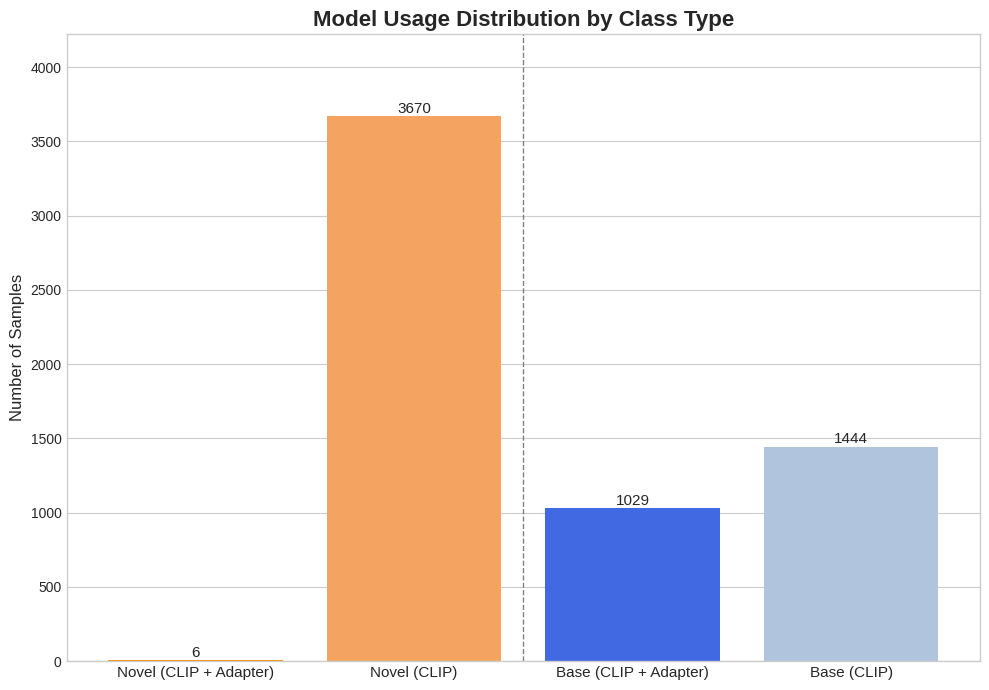

✅ Experiment 1 completed: Base Acc: 92.88%, Novel Acc: 74.81%

📊 RESULTS SUMMARY:
 experiment_id  ctx  alpha  conf_threshold    lr  epochs  base_accuracy  novel_accuracy
             1   13   0.55           0.985 0.001       5      92.883138       74.809576


In [20]:
if __name__ == "__main__":
    # Set a seed for reproducibility
    random.seed(42)
    np.random.seed(42)
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)

    # Run the experiment
    results_df = run_experiments()

---

## References

[1] Kaiyang Zhou, Jingkang Yang, Chen Change Loy, and Ziwei Liu. 2022. Learning to Prompt for Vision-Language Models. International Journal of Computer Vision 130, 9 (July 2022), 2337–2348. Retrieved from https://doi.org/10.1007/s11263-022-01653-1

[2] Naoki Kato, Yoshiki Nota, and Yoshimitsu Aoki. 2024. Proto-Adapter: Efficient Training-Free CLIP-Adapter for Few-Shot Image Classification. Sensors 24, 11 (2024). Retrieved from https://doi.org/10.3390/s24113624

[3] Kaiyang Zhou, Jingkang Yang, Chen Change Loy, and Ziwei Liu. 2022. Conditional Prompt Learning for Vision-Language Models. Retrieved from https://arxiv.org/abs/2203.05557